##Import Libraries

In [ ]:
# Library to support working with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import partial
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from functools import partial
from keras.layers import GRU, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

##Data preprocessing

###Read data

In [ ]:
# Load data
df = pd.read_csv('./data/INTC.csv')
df

###Reset index

In [ ]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [ ]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

###Data normalization

In [ ]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.50906591],
       [0.44962133],
       [0.5122791 ],
       ...,
       [0.15882488],
       [0.14780812],
       [0.18751434]])

###Data splitting

In [ ]:
# Split the data into training, validation and test dataset in a ratio of 7:1:2
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

###Define Model and find the Best Model on the Training and Validation Sets

In [ ]:
#define
units_values = [50, 100, 150, 200]
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5]
optimizer_values = ['adam', 'rmsprop', 'sgd']

#define param_distributions
param_distributions = {
    'units': units_values,
    'dropout': dropout_values,
    'optimizer': optimizer_values
}

#define time_step
time_step_grid = [30, 50, 60, 70, 100]


best_mape = float('inf')
best_model = None
best_params = None
best_time_step = None

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0

    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))

    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)


In [ ]:
def create_model(time_step, units, dropout, optimizer):
    # Define GRU model with current parameters
    model = Sequential()
    model.add(GRU(units, input_shape=(time_step, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
for time_step in time_step_grid:
    print(f"Starting evaluation for time_step: {time_step}")

    X_train, y_train = create_dataset(train_data, time_step)
    last_points_train = train_data[-time_step:]
    X_val, y_val = create_dataset(val_data, time_step, last_points_train)


    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    model = KerasRegressor(build_fn=create_model, time_step=time_step, epochs=100, batch_size=64, verbose=0)

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3)
    random_search.fit(X_train, y_train)

    current_model = random_search.best_estimator_.model

    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    current_model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])

    predictions = current_model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, predictions)

    print(f"Validation MAPE for time_step {time_step}: {mape}")
    print(f"Best parameters for time_step {time_step}: {random_search.best_params_}")

    if mape < best_mape:
        best_mape = mape
        best_model = current_model
        best_params = random_search.best_params_
        best_time_step = time_step
# Print the best overall parameters and score.
print("---------------------------------------")
print(f"Best overall MAPE: {best_mape}")
print(f"Best overall parameters: {best_params}")
print(f"Best overall time_step: {best_time_step}")

Starting evaluation for time_step: 30
4/4 [==============================] - 0s 4ms/step
Validation MAPE for time_step 30: 0.051886485708131265
Best parameters for time_step 30: {'units': 200, 'optimizer': 'adam', 'dropout': 0.2}
Starting evaluation for time_step: 50
4/4 [==============================] - 0s 4ms/step
Validation MAPE for time_step 50: 0.04746978867260581
Best parameters for time_step 50: {'units': 150, 'optimizer': 'adam', 'dropout': 0.1}
Starting evaluation for time_step: 60
4/4 [==============================] - 0s 4ms/step
Validation MAPE for time_step 60: 0.04830200594707091
Best parameters for time_step 60: {'units': 150, 'optimizer': 'adam', 'dropout': 0.3}
Starting evaluation for time_step: 70
4/4 [==============================] - 0s 4ms/step
Validation MAPE for time_step 70: 0.05601164536317746
Best parameters for time_step 70: {'units': 200, 'optimizer': 'adam', 'dropout': 0.1}
Starting evaluation for time_step: 100
4/4 [==============================] - 0s 5m

###Trainning the model with the best parameters.

In [ ]:
# Create training, validation and test datasets with the best time_step
X_train, y_train = create_dataset(train_data, best_time_step)
X_val, y_val = create_dataset(val_data, best_time_step)

last_points_val = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_val)
# Reshape input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

###Training process

In [ ]:
# Create a new model with the best parameters
best_model = create_model(best_time_step, best_params['units'], best_params['dropout'], best_params['optimizer'])

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model with the full training data (train + validation)
best_model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

Epoch 1/100
13/13 [==============================] - 2s 8ms/step - loss: 0.1519
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0126
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0064
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 9/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 11/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 12/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0023
Epoch 13/100
13/13 [=================

In [ ]:
# Now use this to make predictions
y_pred_test = best_model.predict(X_test)

8/8 [==============================] - 0s 3ms/step


###Testing process

In [ ]:
# Invert scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)

In [ ]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test', test_RMSE)
print('MSLE on the data test', test_MSLE)

MAPE on the data test: 0.032364918362805216
RMSE on the data test 1.1724397408567369
MSLE on the data test 0.0014186029458122065


##Predicting the next 30 days

In [ ]:
# Convert the last `best_time_step` days of the test data into the appropriate shape for input to the model
x_input = test_data[-best_time_step:].reshape(1, -1, 1)

temp_input = list(x_input[0])

lst_output = []
i = 0
while(i < 30):
    if len(temp_input) > best_time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1
    else:
        x_input = np.array(temp_input, dtype=np.float32).reshape((1, len(temp_input), 1))
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1


1/1 [==============================] - 0s 23ms/step
0 day input [[[0.17833367]
  [0.18338303]
  [0.18820284]
  [0.18200602]
  [0.18154696]
  [0.17489098]
  [0.17098916]
  [0.1634152 ]
  [0.16593988]
  [0.16043146]
  [0.16616936]
  [0.1590544 ]
  [0.14344732]
  [0.1367914 ]
  [0.12393846]
  [0.10924948]
  [0.09134723]
  [0.095249  ]
  [0.11383982]
  [0.14138165]
  [0.12393846]
  [0.11177415]
  [0.13197154]
  [0.14551297]
  [0.13977507]
  [0.13472572]
  [0.11934818]
  [0.11636444]
  [0.09088825]
  [0.09295389]
  [0.11246268]
  [0.09915077]
  [0.09111776]
  [0.10970851]
  [0.1154464 ]
  [0.12347948]
  [0.10580675]
  [0.09410144]
  [0.05737893]
  [0.09410144]
  [0.1168235 ]
  [0.1501033 ]
  [0.14298826]
  [0.14711955]
  [0.11383982]
  [0.1390865 ]
  [0.14643104]
  [0.15882488]
  [0.14780812]
  [0.18751433]]]
0 day output [[0.18688418]]
1/1 [==============================] - 0s 20ms/step
1 day input [[[0.18338303]
  [0.18820284]
  [0.18200602]
  [0.18154696]
  [0.17489098]
  [0.17098916]
  

In [ ]:
# Invert the scaling
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))

print('Predicted closing prices for the next 30 days:')
for i in range(30):
    print(f"{lst_output[i][0]}")

Predicted closing prices for the next 30 days:
33.042545318603516
33.667720794677734
34.2106819152832
34.744380950927734
35.27724075317383
35.81049346923828
36.34434127807617
36.878787994384766
37.41375732421875
37.94914627075195
38.48481750488281
39.0206298828125
39.55644226074219
40.09209442138672
40.62743377685547
41.16230010986328
41.696529388427734
42.229957580566406
42.762420654296875
43.293758392333984
43.82379913330078
44.35237503051758
44.879329681396484
45.404483795166016
45.92768859863281
46.44877243041992
46.96758270263672
47.483951568603516
47.99773406982422
48.508766174316406


##Visualization

In [ ]:
# Create a date index for the predicted data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

In [ ]:
# Before Plotting Data
# Create index for the training, validation and test data
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size : train_size + val_size]
test_data_index = df.index[train_size + val_size:]

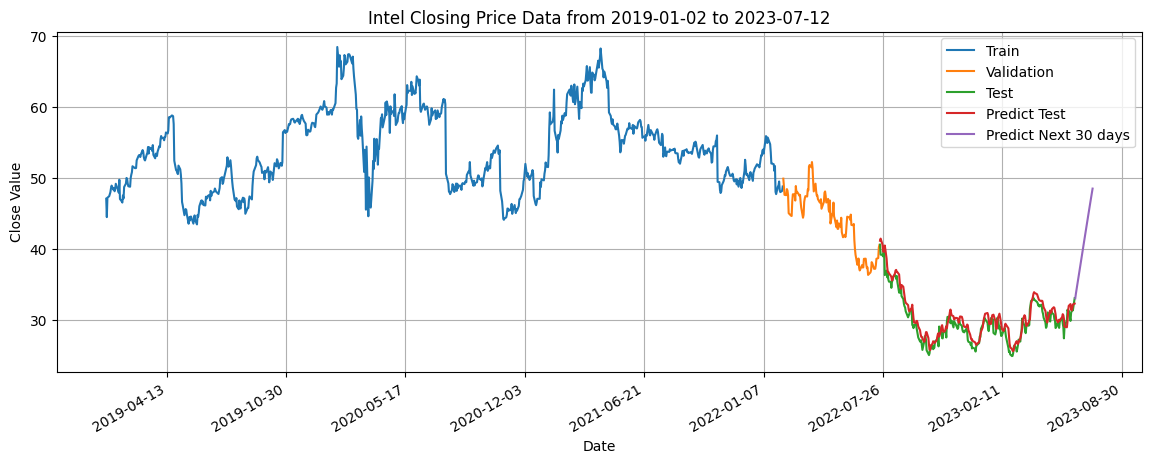

In [ ]:
# Begin Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validation')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')
plt.plot(predict_data_index, lst_output, label='Predict Next 30 days')

# Set up the date markers on the x-axis
plt.grid()
plt.title(f"Intel Closing Price Data from {train_data_index[0].strftime('%Y-%m-%d')} to {predict_data_index[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() # Rotate date labels for better readability
plt.legend()
plt.savefig('./GRU/7_1_2/Image/GRU_712_INTC.png')
plt.show()
